## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

Required imports

In [1]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scraper

plt.rcParams['figure.figsize'] = [10, 8]

If something related to tqdm fails, run:
> `pip install ipywidgets widgetsnbextension pandas-profiling`

Changes?
> `pip freeze > requirements.txt`

## Downloading the data

In [4]:
category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    #"Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph, infos  = await scraper.scrape_wiki(category_titles)

Creating graph: 100%|██████████| 712/712 [00:00<00:00, 11918.68it/s]

Total edges: 19720


A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)

In [5]:
infos.keys()

dict_keys(['titles', 'archive_titles'])

In [6]:
talk_pages = [title for title in page_graph.nodes if title[:5] == "Talk:"]
users = [title for title in page_graph.nodes if title[:5] == "User:"]
print("Number of pages in the vital articles dataset:", len(infos["titles"]))
print("Number of related archived pages:", len(infos["archive_titles"]))
print("Number of users found in relation to the dataset:", len(users))
print("No. nodes", page_graph.number_of_nodes())
print("No. links:", page_graph.number_of_edges())

Number of pages in the vital articles dataset: 100
Number of related archived pages: 612
Number of users found in relation to the dataset: 11103
No. nodes 11303
No. links: 15675


> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)

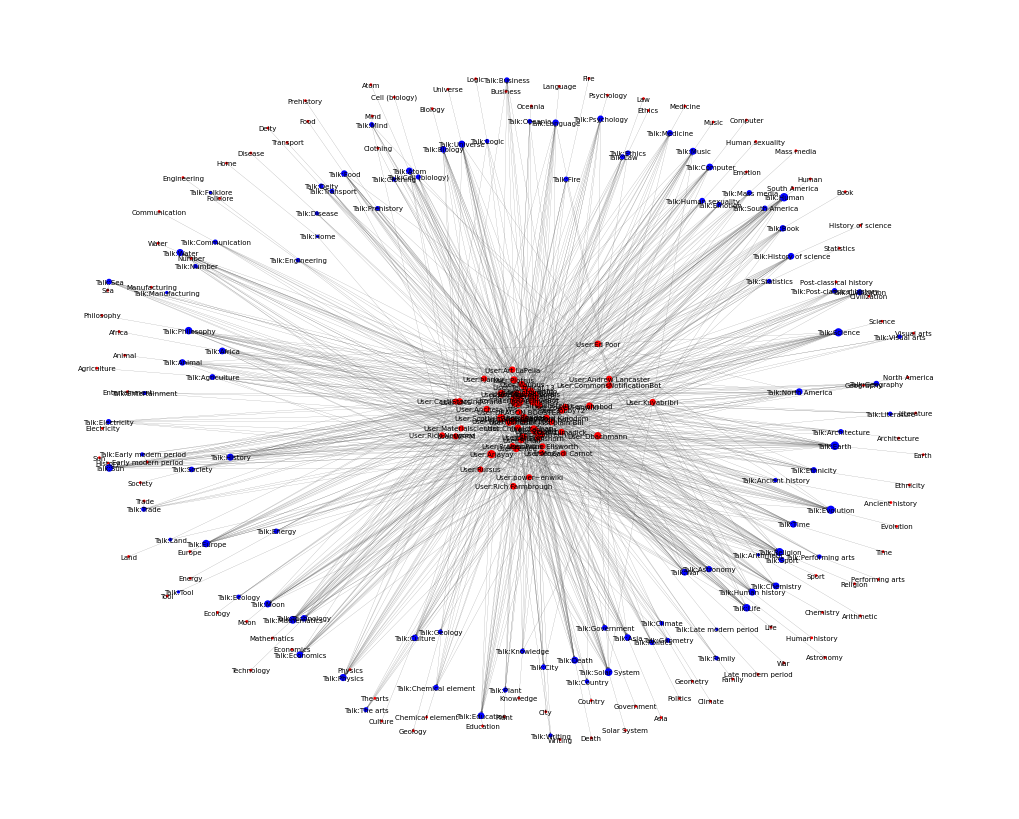

In [7]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Only keep users with a high degree
for node in page_graph.nodes(data=True):
    if "page_class" in node[1]:
        if node[1]["page_class"] == "user":
            if page_graph.out_degree(node[0]) <= 10:
                graph.remove_node(node[0])
    else:
        graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Positions (currently unused)
#pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_talk = "#0000FF"
color_user = "#FF0000"
node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw(rsubgraph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

In [8]:
# sorted(rsubgraph.degree, key=lambda item: item[1], reverse=True)[:10]
import pandas as pd

degrees = pd.DataFrame(rsubgraph.degree, columns=["Node", "Degree"])
degrees.head()

,Node,Degree
0,Talk:Earth,27
1,Earth,1
2,Talk:Human,25
3,Human,1
4,Talk:Human history,16


In [9]:
degrees["PageType"] = ["User" if node[:5] == "User:" else "Talk" for node in degrees.Node ]
users = degrees[degrees.PageType == "User"]
potential_bots = users[users["Node"].str.contains('bot', case=False)]
print(f"{len(potential_bots)} users found with with bot in their name:")
print(",\n".join(potential_bots.Node.values))

5 users found with with bot in their name:
User:Community Tech bot,
User:PrimeBOT,
User:InternetArchiveBot,
User:Cyberbot II,
User:CommonsNotificationBot


After evaluation we found that `User:Botteville`, `User:KP Botany` and `User:NinjaRobotPirate` are human users. Therefore we can filter out the bots by name.


In [10]:
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]

human_users = users[~users["Node"].isin(bot_names)]
n = 10
top_n_human_df = human_users.sort_values(["Degree"], ascending=False).head(n)
top_n_human_df

,Node,Degree,PageType
247,User:Oneiros,38,User
210,User:ScottishFinnishRadish,24,User
229,User:Arjayay,24,User
245,User:Beland,23,User
217,User:Cannolis,22,User
237,User:BozMo,21,User
234,User:Deacon Vorbis,19,User
216,User:Vsmith,19,User
201,User:Piotrus,18,User
205,User:Northamerica1000,18,User


Make subgraph with users and their related pages.



In [11]:
top_n_human_names = top_n_human_df.Node.values
top_users_graph = graph.subgraph(sum([list(graph.neighbors(node)) + [node] for node in top_n_human_names], []))
pages = [node for node in top_users_graph.nodes if node not in top_n_human_names] 

node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in top_users_graph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in top_users_graph.nodes]

In [12]:
degrees = dict(top_users_graph.degree())
sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
top_nodes_count = 10
top_nodes = [node for node in sorted(degrees, key=degrees.get, reverse=True) if node[:5] == "Talk:"][:top_nodes_count]
labels = {node: node for node in top_nodes}

In [13]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=2.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)
pos=forceatlas2.forceatlas2_networkx_layout(top_users_graph, pos=None, iterations=2000)
    
nx.draw(top_users_graph, pos=pos, node_color=node_colors, node_size=node_sizes, edge_color="#999999", width=0.3, alpha=0.5)
plt.show()

ModuleNotFoundError: No module named 'fa2'

Fetching 7356 talk pages:   8%|▊         | 12/148 [01:09<13:04,  5.77s/it]


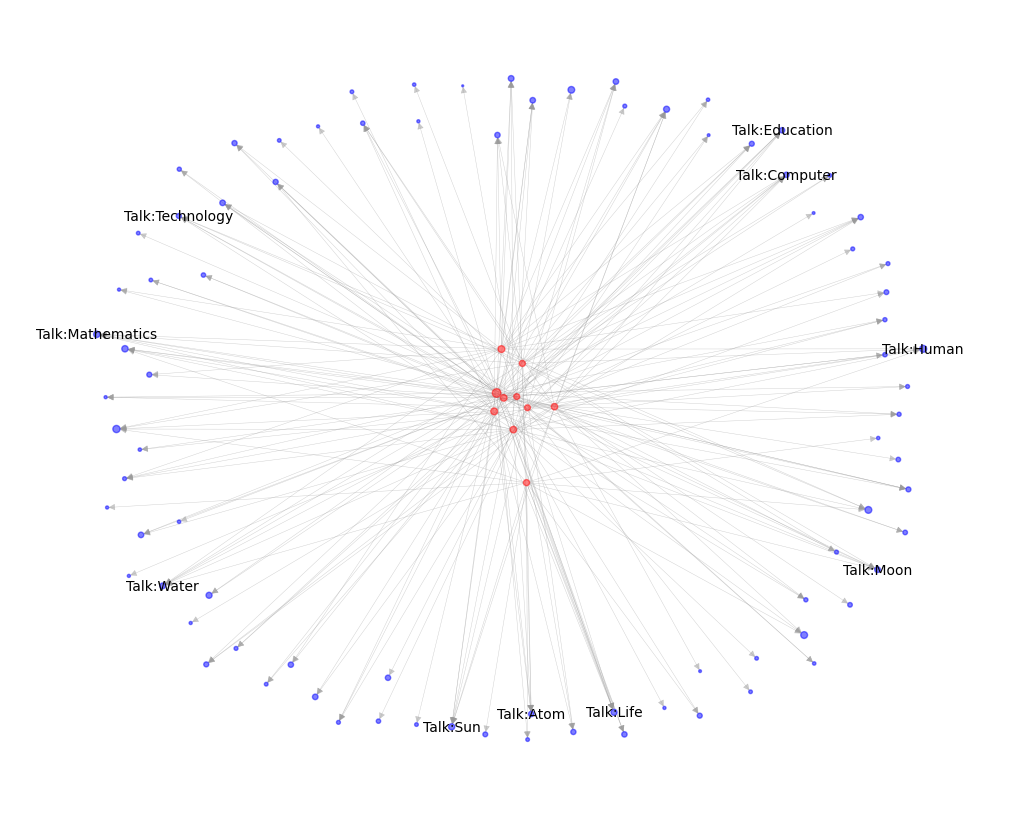

In [14]:
pos = nx.spring_layout(top_users_graph)
label_pos = {node: (pos[node][0], pos[node][1] + 0.15) for node in top_nodes}
nx.draw(top_users_graph, pos=pos, node_color=node_colors, node_size=node_sizes, edge_color="#999999", width=0.3, alpha=0.5, with_labels=False)
nx.draw_networkx_labels(top_users_graph, pos, labels=labels, font_size=10, font_color='black')
plt.show()

## Basic Analysis

In [15]:
import pandas as p
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps

# Basic Statistics

count_nodes = len(page_graph)
count_edges = len(page_graph.edges())

# Create degree statistic dicts
degrees = dict(page_graph.degree())
in_degrees = dict(page_graph.in_degree())
out_degrees = dict(page_graph.out_degree())

talk_page_in_degrees = {k: v for k, v in in_degrees.items() if page_graph.nodes[k]["page_class"] == "talk"}
user_out_degrees = {k: v for k, v in out_degrees.items() if page_graph.nodes[k]["page_class"] == "user"}

def find_top(n, stat_dict):
    degrees_pages = []
    degrees_users = []
    top_overall = ""

    for page, degree in dict(sorted(stat_dict.items(), key=lambda item: item[1], reverse=True)).items():
        if top_overall == "":
            top_overall = page + " - " + str(degree)

        # stat dicts don't distinguish between east/west, so we'll do that here
        if len(degrees_pages) < n and page_graph.nodes[page]["page_class"] == "talk": 
            degrees_pages.append(page + " - " + str(degree))
        elif len(degrees_users) < n and page_graph.nodes[page]["page_class"] == "user":
            degrees_users.append(page + " - " + str(degree))

        if len(degrees_pages) >= n and len(degrees_users) >= n:
            break  # found all top v
    
    return degrees_pages, degrees_users, top_overall

degrees_pages, degrees_users, top_overall = find_top(10, degrees)

print("Number of nodes: " + str(count_nodes))
print("Number of links: " + str(count_edges))

print()
print("Highest degrees for pages:")
print("> Overall:")
print(top_overall)
print("> Pages:")
print("\n".join(degrees_pages))
print("> Users:")
print("\n".join(degrees_users))


# Degree multiplicities
in_degrees_counts = p.Series(talk_page_in_degrees.values()).value_counts()
out_degrees_counts = p.Series(user_out_degrees.values()).value_counts()

max_degree = max([max(in_degrees_counts.index), max(out_degrees_counts.index)])
max_multiplicity = max([max(in_degrees_counts.values), max(out_degrees_counts.values)])
range_x = range(1, max_degree + 1)

in_degrees_counts_interp = in_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()
out_degrees_counts_interp = out_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()

# Exponents
fit_in = powerlaw.Fit(in_degrees_counts.sort_index().values, verbose=False)
fit_out = powerlaw.Fit(out_degrees_counts.sort_index().values, verbose=False)

exp_in = fit_in.alpha
exp_out = fit_out.alpha

print("Exponents:")
print("In-degrees: " + str(exp_in) + " sigma: " + str(fit_in.sigma))
print("Out-degrees: " + str(exp_out) + " sigma: " + str(fit_out.sigma))

Number of nodes: 11303
Number of links: 15675

Highest degrees for pages:
> Overall:
Talk:Evolution - 1176
> Pages:
Talk:Evolution - 1176
Talk:Human - 864
Talk:Earth - 756
Talk:Moon - 531
Talk:Sun - 518
Talk:Europe - 516
Talk:Religion - 459
Talk:Solar System - 375
Talk:Mathematics - 371
Talk:Philosophy - 366
> Users:
User:InternetArchiveBot - 79
User:Cyberbot II - 45
User:PrimeBOT - 40
User:Oneiros - 38
User:Community Tech bot - 24
User:ScottishFinnishRadish - 24
User:Arjayay - 24
User:Beland - 23
User:Cannolis - 22
User:BozMo - 21
Exponents:ess: 94%
In-degrees: 40.46085539802291 sigma: 9.865213849505727
Out-degrees: 1.4447556674551814 sigma: 0.11118891686379534


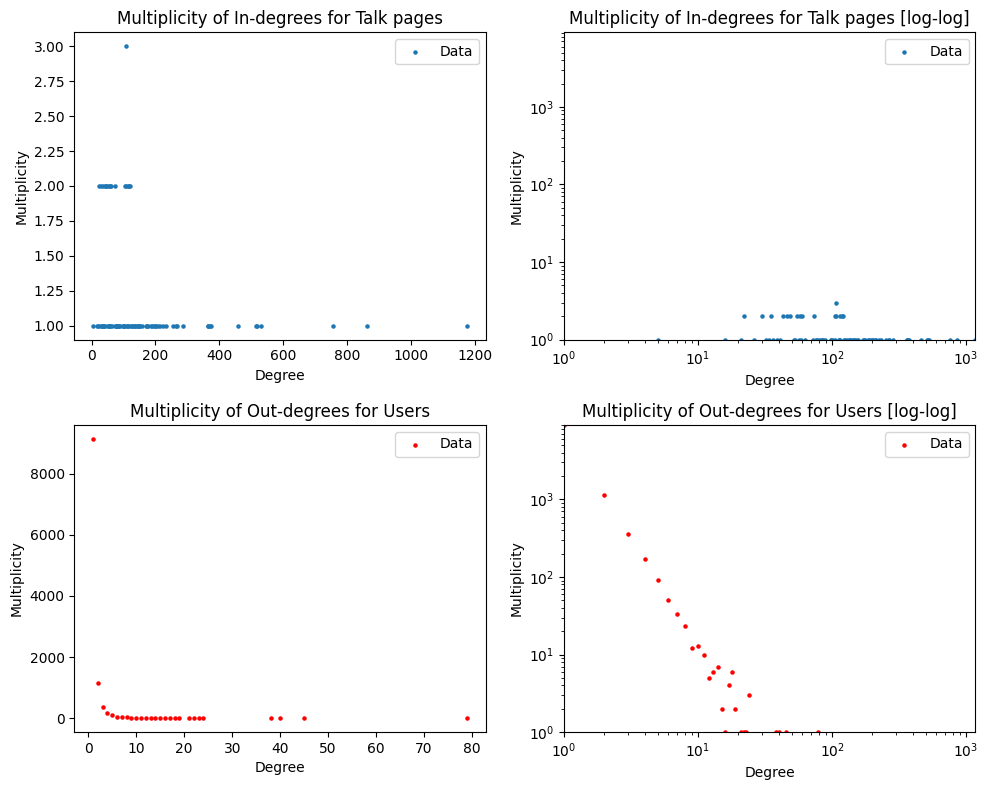

In [16]:
import math
def fpl(x, a):
    return x ** (-a)

# Plots
fig, axs = plt.subplots(2, 2)

# Sturges rule
no_bins_sturges = int(1 + math.log(len(talk_page_in_degrees.values()), 2))

axs[0, 0].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#hist, bin_edges, _ = axs[0, 0].hist(talk_page_in_degrees.values(), bins=no_bins_sturges, edgecolor='white', label='Data')
#axs[0, 0].set_xticks(bin_edges)
#axs[0, 0].set_xticklabels(['%.0f' % val for val in bin_edges], rotation=45)
axs[0,0].set_title('Multiplicity of In-degrees for Talk pages')
axs[0,0].legend()

axs[0,1].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
#axs[0,1].plot(range_x, fpl(range_x, exp_in) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_title('Multiplicity of In-degrees for Talk pages [log-log]')
axs[0,1].set_xlim(1, max_degree)
axs[0,1].set_ylim(1, max_multiplicity)
axs[0,1].legend()

axs[1, 0].scatter(out_degrees_counts.index, out_degrees_counts.values, color="red", s=5, label='Data')
# hist, bin_edges, _ = axs[1, 0].hist(talk_page_in_degrees.values(), bins=no_bins_sturges, color="red", edgecolor='white', label='Data')
# axs[1, 0].set_xticks(bin_edges)
# axs[1, 0].set_xticklabels(['%.0f' % val for val in bin_edges], rotation=45)
axs[1,0].set_title('Multiplicity of Out-degrees for Users')
axs[1,0].legend()

axs[1,1].scatter(out_degrees_counts.index, out_degrees_counts.values, s=5, label='Data', color="red")
#axs[1,1].plot(range_x, fpl(range_x, exp_out) * count_nodes, 'k-', lw=1, alpha=.75, label='Power Law fit')
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_title('Multiplicity of Out-degrees for Users [log-log]')
axs[1,1].set_xlim(1, max_degree)
axs[1,1].set_ylim(1, max_multiplicity)
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='Degree', ylabel='Multiplicity')

fig.tight_layout()

In [59]:
import os
import wikichatter as wc 
import mwparserfromhell as mwpfh

import nltk
from nltk.tokenize import word_tokenize
import re
from dateutil.parser import parse

wnl = nltk.WordNetLemmatizer()

# extract comments,
parsed_comments = []
for filename in os.listdir('./page_contents/')[:20]:
    filename = os.path.join('./page_contents', filename)
    if filename.endswith('.txt'):
        #print(filename)
        with open(filename, 'r') as file:
            text = file.read()
            try:
                parsed = wc.parse(text)
                parsed_comments.append((filename, parsed))
            except:
                print("failed to parse: " + filename)

author_dict = {}

def parse_comment(comment):
    for text in comment["text_blocks"]:
        if(not text.startswith('=')):
            #wikilink_regex = r'\[\[.*?\]\]|\(\)|\{\{.*?\{\}'
            wikilink_regex = r'\(\)|\{\{.*?\{\}'
            one_comment = re.sub(wikilink_regex, '', text)

            one_comment_words = word_tokenize(one_comment)
            #one_comment_words = [word for word in one_comment_words if word.isalnum()]
            if (len(text) > 0):
                yield ' '.join(one_comment_words)

def parse_comment_subcomment(comment):
        yield (comment.get("author"), ' '.join(list(parse_comment(comment))))

        if comment.get("comments"):
            parse_comment_subcomment(comment.get("comments"))

for filename, page in parsed_comments:
    print("page: ", filename)
    for subsection in page["sections"]:
        if subsection.get("heading"):
            print("subsection: ", subsection.get("heading"))
            for comments in subsection.get("comments"):
                if comments.get("author"):
                        print("comments: ", list(parse_comment_subcomment(comments)))

page:  ./page_contents/Talk:Africa.txt
subsection:   Coats of Arms 
comments:  [('Joaquin89uy', " Lybia and S. Africa 's coats of arms are not showing on the list that appears near the end of the article . I checked out the code but I do n't know how to fix it . - [ [ User : Joaquin89uy|Joaquin89uy ] ] ( [ [ User talk : Joaquin89uy|talk ] ] ) 18:10 , 4 February 2023 ( UTC )")]
subsection:   Emergence of civilization 
comments:  [('PabloGeru', " `` Sorghum was first domesticated in Eastern Sudan around 4000 BCE , in one of the earliest instances of agriculture in human history . Its cultivation would gradually spread across Africa , before spreading to India around 2000 BCE .  Colossal statues of Ramesses II at Abu Simbel , Egypt , date from around 1400 BCE . '' '' 'Sorghum was first domesticated in the '' '' ' [ clarification needed ] . '' the phrase `` Sorghum was first domesticated in the '' is duplicated in the text , in the second case the phrase is unfinished . I think that the se